In [1]:
from CO2xSWV import fetch_data_from_NEON_API, make_df
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import multiprocessing
from dataclasses import dataclass
import xarray as xr
import scipy.stats as stats

from dask import delayed
import dask
from dask.diagnostics import ProgressBar

multiprocessing.cpu_count()

16

```fetch_data``` is commment out bc the files were already downloaded while i was working on this

In [14]:
sitecodes = ['BART', 'ABBY', 'TEAK']
productcodes = ['DP1.00095.001', 'DP1.00094.001','DP1.00041.001']
daterange = ['2015-01', '2020-11']
# fetch_data_from_NEON_API(sitecodes, productcodes, daterange=daterange)
# TODO: optimize dask for cyverse, 

In [2]:
# glob files for the site
data_path='/home/jovyan/NEON/CO2xSWV_data'
site = 'TEAK'
soil_CO2 = glob.glob(f'{data_path}/*{site}*SCO2C_1_minute*.csv')
soil_H2O = glob.glob(f'{data_path}/*{site}*SWS_1_minute*.csv')
soil_T   = glob.glob(f'{data_path}/*{site}*ST_1_minute*.csv')
# make lists with date, and files for that date
sc = set([f.split('.')[-4] for f in soil_CO2])
sw = set([f.split('.')[-4] for f in soil_H2O])
st = set([f.split('.')[-4] for f in soil_T])
# find dates present in all data products
dates = list(sc & sw & st)
dates.sort()
# make seperate lists of each product for the dates where all are present
c = []
w = []
t = []
for date in dates:
    c = c + [f for f in soil_CO2 if date in f]
    w = w + [f for f in soil_H2O if date in f]
    t = t + [f for f in soil_T if date in f]
# Now we have all of the files for the site in seperate lists by product

# find the HOR-VER combinations present for all dates at site
horvers = []
for date in dates:
    #find files for the date
    cc = [f for f in c if date in f]
    ww = [f for f in w if date in f]
    tt = [f for f in t if date in f]
    #find HOR and VER combinations for the date (e.g. '003501')
    ccc = [''.join(f.split('.')[6:8]) for f in cc]
    www = [''.join(f.split('.')[6:8]) for f in ww]
    ttt = [''.join(f.split('.')[6:8]) for f in tt]
    horver = list(set(ccc) & set(www) & set(ttt))
    horvers.append(horver)
    
horver = set(horvers[0])   
for hv in horvers[1:]:
    horver = horver & set(hv)
horver = list(horver)

hor = list(set([hv[:3] for hv in horver]))
hor.sort()
hor_ver = [[hv[:3], hv[3:]] for hv in horver]
horver = {key : [] for key in hor}
for key, val in hor_ver:
    horver[key].append(val)

# horver is a dict all HOR-VER combinations available at  site
# its like {Hor : [z1, z2,...]}

In [3]:
horver

{'001': ['501', '502', '503'],
 '002': ['501', '502', '503'],
 '003': ['501', '503', '502'],
 '004': ['501', '502', '503'],
 '005': ['501', '502']}

In [4]:
# make a hourly df for each hor
# TODO: maybe add progress barr like,
# with ProgressBar():
#     result = list(dask.compute(*lazy))

lazy = []

#for hor, vers in horver.items():
hor = '004'
vers = horver['001'][:2]
for ver in vers:
    lazy = []
    for date in dates:
        lazy.append(make_df(hor, ver, date, site, data_path))
    result = list(dask.compute(*lazy))

# concat all the monthly dfs for the HOR.VER into 1
result = [thing for thing in result if len(thing) > 0]
df = pd.concat(result)        


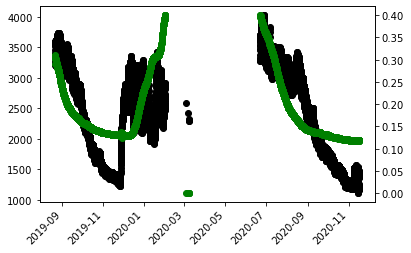

In [5]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df.index, df.soilCO2concentrationMean, c='k')
ax2.scatter(df.index, df.VSWCMean, c='g')
fig.autofmt_xdate(rotation=45)

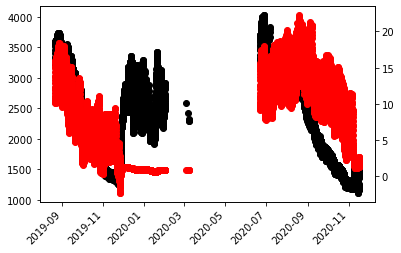

In [6]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df.index, df.soilCO2concentrationMean, c='k')
ax2.scatter(df.index, df.soilTempMean, c='r')
fig.autofmt_xdate(rotation=45)

Text(0.5, 0, 'CO2 (ppm?)')

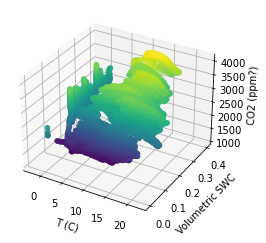

In [7]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x = df.soilTempMean
y = df.VSWCMean
z = df.soilCO2concentrationMean

ax.scatter(x, y, z, c=z)

ax.set_xlabel('T (C)')
ax.set_ylabel('Volumetric SWC')
ax.set_zlabel('CO2 (ppm?)')

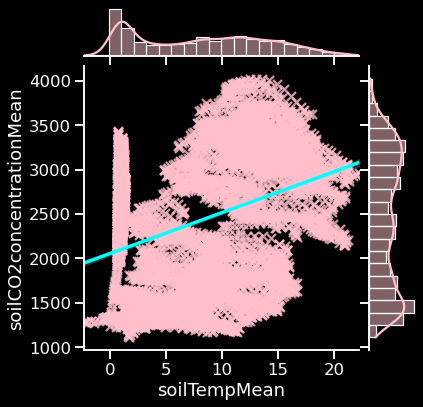

In [8]:
sns.set(style='ticks', context='talk')
plt.style.use('dark_background')
j = sns.jointplot(x='soilTempMean', y='soilCO2concentrationMean', data=df, kind = 'reg', color='pink', marker = 'x', joint_kws={'line_kws':{'color':'cyan'}})
# aack I wosh seabor would give us r and p!


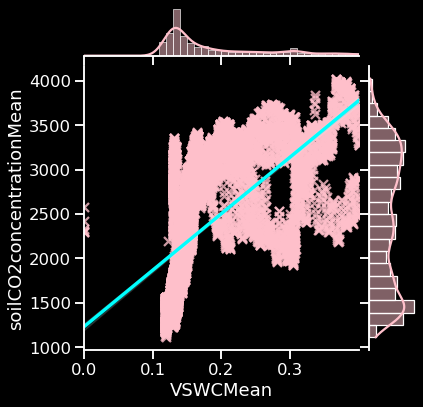

In [9]:
sns.set(style='ticks', context='talk')
plt.style.use('dark_background')
j = sns.jointplot(x='VSWCMean', y='soilCO2concentrationMean', data=df, kind = 'reg', color='pink', marker = 'x', joint_kws={'line_kws':{'color':'cyan'}})


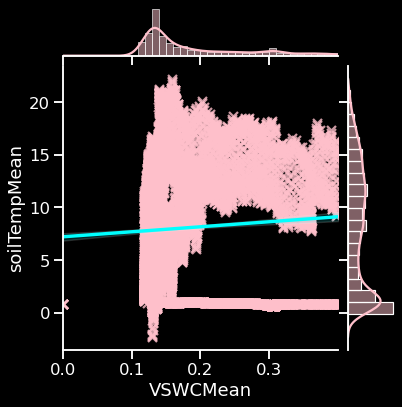

In [10]:
sns.set(style='ticks', context='talk')
plt.style.use('dark_background')
j = sns.jointplot(x='VSWCMean', y='soilTempMean', data=df, kind = 'reg', color='pink', marker = 'x', joint_kws={'line_kws':{'color':'cyan'}})


### 1) ###
Judging from all of these plots I think there might be a T sensor malfunction insome of the data. Also, double check the sensor positions to make sure the T ansd H2O sensors are lined up. Extract the actual z offset for each from the senor positions to report with each analysis.  Probably ultimately w will want to save a pdf for each sensor with graPHS AND STATISTICAL INFO.

### 2) ###

__a)__ For each dataset in the training sets split to train and validations sets.

__b)__ Create a model. validate.

__c)__ Validate on holdout sites.


In [15]:
from CO2xSWV import sensor_positions
for product in productcodes:
    sensor_positions(product, site, date, data_path)